## OMNI-HYPE-SMT Tutorial

This Jupyter notebook is meant to serve as a tutorial for fitting the OMNI-HYPE-SMT model to hypergraph data in Python. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import omni 

### Loading the data

The model takes in an input of `counts`, a numpy array of length $N$ and edges, a matrix of size $N \times D$. Each row in `edges` specifies a hyperedge. For hyperedges of length $d$ less than $D$, the row should be padded with zeros. 

In [2]:
data = np.load("data/supreme-court/edges.npz") #data file should be called edges.npz, with two items: 'edges' and 'counts'
edges = data['edges'] #the non-zero edges, an N by D numpy array.
counts = data['counts'] #the number of edges for each node, a length-N numpy array

print("Example edges (first 5 rows):") #print first 5 rows of edges and counts
print(edges[:5])
print("Example counts (first 5 rows):")
print(counts[:5])

Example edges (first 5 rows):
[[1. 2. 3. 4. 5. 6. 7. 8. 9.]
 [1. 2. 3. 4. 5. 6. 7. 9. 0.]
 [1. 2. 3. 4. 5. 6. 8. 9. 0.]
 [1. 2. 3. 4. 5. 6. 9. 0. 0.]
 [1. 2. 3. 4. 5. 7. 8. 9. 0.]]
Example counts (first 5 rows):
[44  1  1  1  1]


Set the following hyperparameters as you see fit. Each is accompanied by a brief description.

In [3]:
directory = "supreme-court" #the name of the directory your 'edges.npz' file lives 
test = True #if true, masks proportion of data as described in paper
C = 3 #number of classes 
K = 6 # number of communities (mixtures of classes). Set K >= C
model = "semi" #"semi" (faster) or "omni" (slower but more flexible) 
MIN_ORDER = 2 #set >= 2
MAX_ORDER = 9 #D in paper
CONV_TOL = 1 #convergence tolerance for change in log likelihood
MAX_ITER = 1000 #maximum number of iterations before stopping
LEARNING_RATE = 1e-6 #learning rate for gradient ascent step
NUM_RESTARTS = 10 #number of random restarts
NUM_STEPS = 1 #steps of gradient ascent per iteration: set to 1 by default
CHECK_EVERY = 10 #compute log likelihood every CHECK_EVERY iterations
seed = 123 #random seed, for reproducibility

After setting your parameters above, run the following line to fit your model. The `omni.fit_omni` function returns a dictionary with $\mathrm{W}, \Theta, \text{ and } \Gamma$.

In [4]:
output = omni.fit_omni(directory="supreme-court", test=False, C=C, K=K, model=model, MIN_ORDER=MIN_ORDER, 
MAX_ORDER=MAX_ORDER, CONV_TOL=CONV_TOL, MAX_ITER=MAX_ITER, LEARNING_RATE=LEARNING_RATE, NUM_RESTARTS=NUM_RESTARTS,
NUM_STEPS=NUM_STEPS, CHECK_EVERY=CHECK_EVERY, seed=seed)

In [5]:
w_KC = np.array(output['w_KC']).T
Theta_IC = np.array(output['Theta_IC']).T
Theta_IC /= Theta_IC.sum(axis=0, keepdims=True)  # Normalize columns to sum to 1
gammas_DK = np.array(output['gammas_DK']).T

### Visualizing the class-community matrix ${\mathrm{W}}$ and class-membership matrix $\Theta$

Below, we can visualize the class-community matrix $\mathrm{W}$.

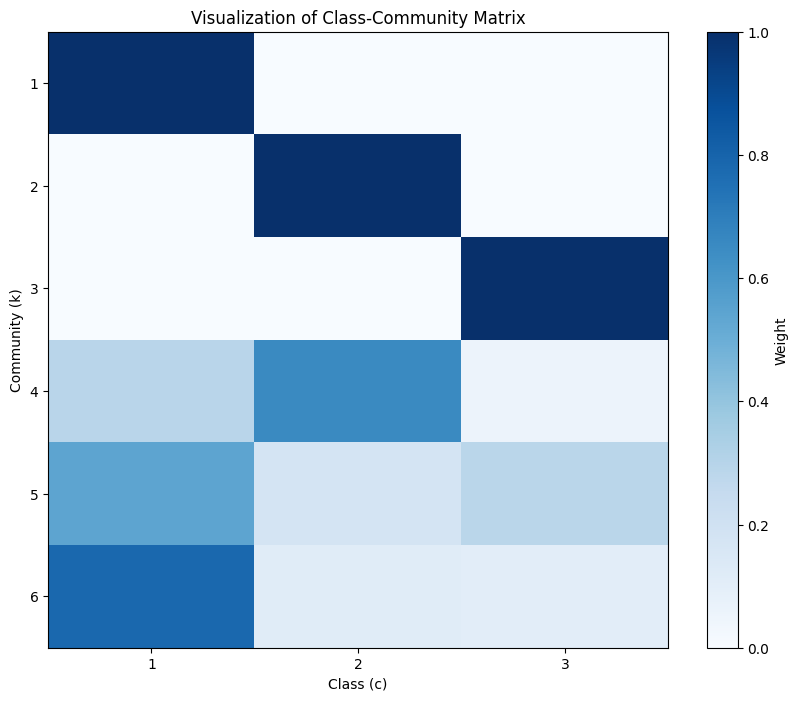

In [6]:
plt.figure(figsize=(10, 8))
plt.imshow(w_KC, aspect='auto', cmap='Blues')
plt.colorbar(label='Weight')
plt.title('Visualization of Class-Community Matrix')
plt.xlabel('Class (c)')
plt.ylabel('Community (k)')
plt.xticks(np.arange(w_KC.shape[1]), [i+1 for i in range(w_KC.shape[1])])
plt.yticks(np.arange(w_KC.shape[0]), [i+1 for i in range(w_KC.shape[0])])
plt.show()

Since we fit our model to the `supreme-court` dataset, we load the names of the Justices below.

In [7]:
#load justice names 
maps = np.load('data/supreme-court/justice_map.npz', allow_pickle=True)
rev_justice_map2 = {v: k for k, v in maps['justice_map2'].tolist().items()}
justice_names = []
for i in range(Theta_IC.shape[0]):
    justice_names.append(maps['justice_map'].tolist()[rev_justice_map2[i]])

We then sort the rows of $\Theta$ to give a better depiction of the block structure captured by the model. 

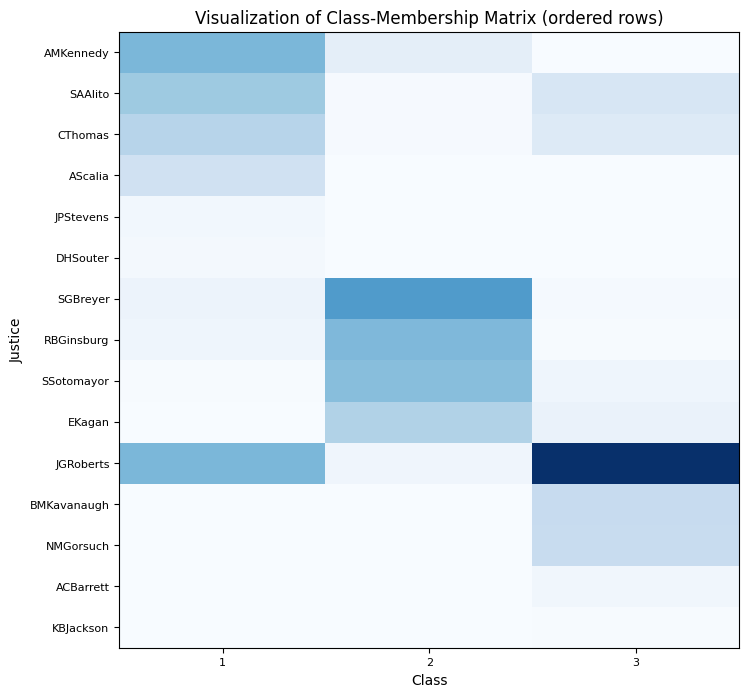

In [8]:
hardmax = np.argmax(Theta_IC, axis=1)
hardmax_matrix = np.zeros_like(Theta_IC)
sorted_inds = np.zeros_like(hardmax).astype(int)
C = 3
counter = 0
justice_names = np.array(justice_names).astype(str)
for i in range(C):
    inds = np.where(hardmax == i)[0]
    hardmax_matrix[counter:counter+len(inds), :] = Theta_IC[inds,:]
    sorted_inds[counter:counter+len(inds)] = inds
    sorted_inds[counter:counter+len(inds)] = sorted_inds[counter:counter+len(inds)][np.argsort(-hardmax_matrix[counter:counter+len(inds), i])]
    hardmax_matrix[counter:counter+len(inds),:] = hardmax_matrix[counter:counter+len(inds), :][np.argsort(-hardmax_matrix[counter:counter+len(inds), i])]
    counter += len(inds)

sorted_names = justice_names[sorted_inds]


plt.figure(figsize = (8,8))
plt.imshow(hardmax_matrix, cmap='Blues', aspect='auto')
plt.gca().tick_params(axis='y', labelcolor='black')  # Keep tick labels black
plt.xticks(ticks=np.arange(C), labels=np.arange(1,C+1), fontsize=8)
plt.yticks(ticks=np.arange(len(sorted_names)), labels=sorted_names, fontsize=8)
plt.xlabel('Class')
plt.ylabel('Justice')
plt.title("Visualization of Class-Membership Matrix (ordered rows)")
plt.show()